## Baseline Models: Naive Bayes and Logistic Regression

### Step 1: Load CSV and Filter Five Major Banks

We begin by loading the full complaint dataset and filtering only the following five banks, which have more balanced label distributions for 'Company response to consumer':

- BANK OF AMERICA, NATIONAL ASSOCIATION  
- JPMORGAN CHASE & CO.  
- CAPITAL ONE FINANCIAL CORPORATION  
- CITIBANK, N.A.  
- WELLS FARGO & COMPANY

In [1]:
import pandas as pd
import numpy as np

# Load the full complaints dataset
file_path = '/content/complaints_selected_five_banks.csv'
df = pd.read_csv(file_path)

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Define the 5-bank list
target_banks = [
 #   'BANK OF AMERICA, NATIONAL ASSOCIATION',
 #   'JPMORGAN CHASE & CO.',
 #   'CAPITAL ONE FINANCIAL CORPORATION',
    'CITIBANK, N.A.'
 #   ,'WELLS FARGO & COMPANY'
]

# Filter only the selected banks
df_banks = df[df['company'].isin(target_banks)].copy()

# Check results
print("Filtered dataset shape:", df_banks.shape)
print("Unique banks:", df_banks['company'].unique())

Filtered dataset shape: (110168, 18)
Unique banks: ['CITIBANK, N.A.']


### Step 2: Initial Quality Check

We check for missing values and label distribution to ensure our model will be learning from clean, relevant data. This also helps assess balance between response types.

In [2]:
# Check null values
print("Missing values per column:")
print(df_banks.isnull().sum())

# Check label distribution
print("\nDistribution of 'company_response_to_consumer':")
print(df_banks['company_response_to_consumer'].value_counts())

Missing values per column:
date_received                       0
product                             0
sub-product                     17114
issue                               0
sub-issue                       35104
consumer_complaint_narrative    65198
company_public_response         20703
company                             0
state                            1719
zip_code                         1000
tags                            92540
consumer_consent_provided?      34876
submitted_via                       0
date_sent_to_company                0
company_response_to_consumer        1
timely_response?                    0
consumer_disputed?              75400
complaint_id                        0
dtype: int64

Distribution of 'company_response_to_consumer':
company_response_to_consumer
Closed with explanation            71739
Closed with monetary relief        19030
Closed with non-monetary relief    17043
Closed without relief               1347
Closed with relief                

### Step 3: Count and Ratio of Complaint Narratives by Company and Response Type

We compute the following for each (`company`, `company_response_to_consumer`) group:
- Total complaint count
- Number of complaints with a narrative
- Ratio of narrative presence
- Percentage that each response type makes up within a company

We also visualize the result with company-wise spacing to improve readability.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and calculate counts
grouped = (
    df_banks
    .groupby(['company', 'company_response_to_consumer'])
    .agg(
        total_complaints=('company', 'count'),
        narrative_count=('consumer_complaint_narrative', lambda x: x.notna().sum())
    )
    .reset_index()
)

# Compute ratios
grouped['narrative_ratio'] = (grouped['narrative_count'] / grouped['total_complaints']).round(2)

# Compute within-company response label share
total_by_company = grouped.groupby('company')['total_complaints'].transform('sum')
grouped['response_ratio_within_company'] = (grouped['total_complaints'] / total_by_company).round(2)

# Sort for plotting
grouped = grouped.sort_values(by=['company', 'total_complaints'], ascending=[True, False])

# Display the summary
display(grouped)

,company,company_response_to_consumer,total_complaints,narrative_count,narrative_ratio,response_ratio_within_company
1,"CITIBANK, N.A.",Closed with explanation,71739,29083,0.41,0.65
2,"CITIBANK, N.A.",Closed with monetary relief,19030,8662,0.46,0.17
3,"CITIBANK, N.A.",Closed with non-monetary relief,17043,7203,0.42,0.15
5,"CITIBANK, N.A.",Closed without relief,1347,0,0.00,0.01
4,"CITIBANK, N.A.",Closed with relief,681,0,0.00,0.01
0,"CITIBANK, N.A.",Closed,176,13,0.07,0.00
6,"CITIBANK, N.A.",In progress,81,9,0.11,0.00
7,"CITIBANK, N.A.",Untimely response,70,0,0.00,0.00


### Step 3b: Visualize Narrative Counts by Company and Response Type

We use a grouped bar chart to compare narrative counts across response types.
Each company is spaced out for better visual clarity.

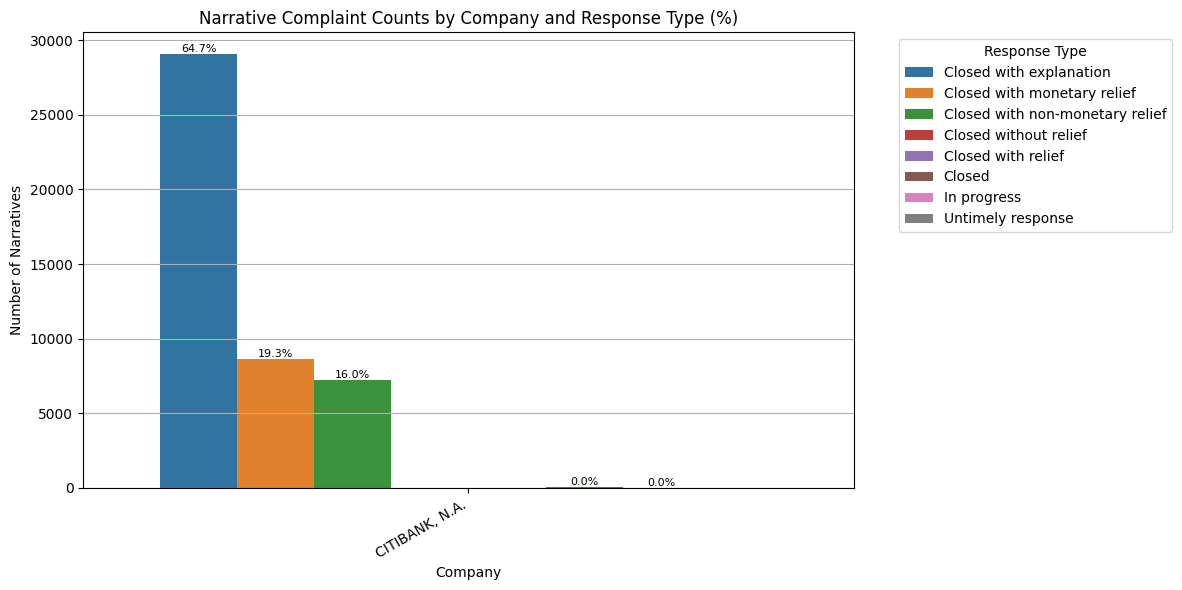

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new figure
plt.figure(figsize=(12, 6))

# Plot bar chart
ax = sns.barplot(
    data=grouped,
    x='company',
    y='narrative_count',
    hue='company_response_to_consumer',
    palette='tab10'
)

# Add % labels on top of each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            # Get corresponding company and response type from bar position
            x_pos = bar.get_x() + bar.get_width() / 2
            bar_index = list(ax.containers).index(container)
            bar_label = bar.get_label()  # the response type
            company_label = ax.get_xticklabels()[int(x_pos)].get_text()

            # Get total narrative count for this company
            total_narratives = grouped[grouped['company'] == company_label]['narrative_count'].sum()
            pct = (height / total_narratives) * 100

            # Annotate
            ax.annotate(f"{pct:.1f}%",
                        (bar.get_x() + bar.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8, color='black', rotation=0)

# Final touches
plt.xticks(rotation=30, ha='right')
plt.xlabel("Company")
plt.ylabel("Number of Narratives")
plt.title("Narrative Complaint Counts by Company and Response Type (%)")
plt.legend(title="Response Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

### Step 4: Filter to Three Key Response Categories

We narrow our master dataset down to only the three “closed” categories we care about:

- **Closed with explanation**  
- **Closed with monetary relief**  
- **Closed with non-monetary relief**  

All other response types are dropped as noise.

In [5]:
# Step 4: Keep only the 3 desired response categories
keep_responses = [
    'Closed with explanation',
    'Closed with monetary relief',
    'Closed with non-monetary relief'
]

df_filtered = df_banks[
    df_banks['company_response_to_consumer'].isin(keep_responses)
].copy()

print("After filtering, dataset shape:", df_filtered.shape)
print("Remaining response types:\n",
      df_filtered['company_response_to_consumer'].value_counts())

After filtering, dataset shape: (107812, 18)
Remaining response types:
 company_response_to_consumer
Closed with explanation            71739
Closed with monetary relief        19030
Closed with non-monetary relief    17043
Name: count, dtype: int64


### Step 5: Create Binary Target for Monetary Relief

We convert the three categories into a **binary target**:
- **1** if “Closed with monetary relief”  
- **0** if “Closed with explanation” or “Closed with non-monetary relief”

In [6]:
df_filtered['monetary_relief'] = np.where(
    df_filtered['company_response_to_consumer'] == 'Closed with monetary relief',
    1,
    0
)

print("Value counts for target 'monetary_relief':\n",
      df_filtered['monetary_relief'].value_counts())

Value counts for target 'monetary_relief':
 monetary_relief
0    88782
1    19030
Name: count, dtype: int64


### Step 6: Select Features and One-Hot Encode

We will use the categorical attributes:
- **product**  
- **sub-product**  
- **issue**  
- **sub-issue**

We one-hot encode these four columns to prepare for a baseline classifier.

In [7]:
# Select our features and the target
features = ['product', 'sub-product', 'issue', 'sub-issue']
X_cat = df_filtered[features]
y = df_filtered['monetary_relief']

# One-hot encode
X_structured = pd.get_dummies(X_cat, drop_first=True)

print("Feature matrix shape after one-hot encoding:", X_structured.shape)

Feature matrix shape after one-hot encoding: (107812, 475)


In [8]:
# Export selected categorical and text features to CSV for further modeling
citi_input_features = df_filtered[['product', 'sub-product', 'issue', 'sub-issue', 'consumer_complaint_narrative', 'monetary_relief']]
citi_input_features.to_csv("citi_input_features.csv", index=False)

### Step 7: TF-IDF Vectorization of Customer Complaint Texts

We will process the complaint narratives as follows:  
- **Clean the text** by removing punctuation, numbers, and extra spaces, and converting to lowercase  
- **Generate TF-IDF features** using unigrams and bigrams, limited to the top 1,000 terms  

We use the resulting feature matrix as input for our baseline classifier.

In [9]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove punctuation and numbers, keep only letters and spaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning to the complaint narrative
df_filtered['cleaned_narrative'] = df_filtered['consumer_complaint_narrative'].apply(clean_text)

# Generate TF-IDF features from the cleaned text
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # using unigrams and bigrams
X_tfidf = tfidf.fit_transform(df_filtered['cleaned_narrative'])

print("TF-IDF feature matrix shape:", X_tfidf.shape)

TF-IDF feature matrix shape: (107812, 1000)


### Step 8: Sentiment Feature Extraction from Customer Complaint Texts

We extract sentiment scores from the cleaned complaint narratives using TextBlob:  
- **Polarity** indicates sentiment from negative (-1) to positive (+1)  
- **Subjectivity** measures the degree of personal opinion from objective (0) to subjective (1)  

These features are added as new columns and used to enrich the input for classification.

In [10]:
from textblob import TextBlob

# Extract sentiment polarity and subjectivity using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return pd.Series({
        'polarity': blob.sentiment.polarity,         # [-1, 1], negative to positive
        'subjectivity': blob.sentiment.subjectivity  # [0, 1], objective to subjective
    })

# Apply sentiment scoring to each narrative
df_filtered[['polarity', 'subjectivity']] = df_filtered['cleaned_narrative'].apply(get_sentiment)

# Preview results
print(df_filtered[['cleaned_narrative', 'polarity', 'subjectivity']].head())

                                    cleaned_narrative  polarity  subjectivity
0                                                      0.000000      0.000000
9   im just mailing you to let you know respectful...  0.113170      0.744420
11                                                     0.000000      0.000000
13                                                     0.000000      0.000000
25  on xxxxyear a fraudulent charge of was made on... -0.014815      0.314815


### Step 9: Train/Test Split for Naive Bayes

We combine structured features, TF-IDF vectors, and scaled sentiment scores to form the final input matrix:  
- **Sentiment features** (`polarity`, `subjectivity`) are scaled using MinMaxScaler  
- **All features** are horizontally stacked into a sparse matrix for modeling  

We then split the data into training and test sets with stratified sampling to preserve label balance.

In [11]:
from scipy.sparse import hstack
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Extract and scale sentiment features
sentiment_raw = df_filtered[['polarity', 'subjectivity']].fillna(0).astype(float).values
scaler = MinMaxScaler()
sentiment_scaled = scaler.fit_transform(sentiment_raw)

# X with scaled sentiment features
X_nb = hstack([X_structured.values, X_tfidf, sentiment_scaled])

X_train_nb, X_test_nb, y_train, y_test = train_test_split(
    X_nb, y, test_size=0.2, random_state=42, stratify=y
)

print("Final feature matrix shape:", X_nb.shape)
print("Train shape:", X_train_nb.shape, "Test shape:", X_test_nb.shape)
print("Train target balance:\n", y_train.value_counts(normalize=True))
print("Test  target balance:\n", y_train.value_counts(normalize=True))

Final feature matrix shape: (107812, 1477)
Train shape: (86249, 1477) Test shape: (21563, 1477)
Train target balance:
 monetary_relief
0    0.823488
1    0.176512
Name: proportion, dtype: float64
Test  target balance:
 monetary_relief
0    0.823488
1    0.176512
Name: proportion, dtype: float64


### Step 10: Naive Bayes Model Training and Evaluation

We train a baseline **Multinomial Naive Bayes** classifier using the combined feature set:  
- **Fit** the model on the training data  
- **Predict** outcomes on the test set  
- **Evaluate** performance using accuracy, classification report, and confusion matrix

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_nb, y_train)

# Predict
y_pred = nb_model.predict(X_test_nb)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7458145898066132

Classification Report:
               precision    recall  f1-score   support

           0     0.9087    0.7686    0.8328     17757
           1     0.3720    0.6395    0.4704      3806

    accuracy                         0.7458     21563
   macro avg     0.6403    0.7041    0.6516     21563
weighted avg     0.8139    0.7458    0.7688     21563


Confusion Matrix:
 [[13648  4109]
 [ 1372  2434]]


### Step 11: Train/Test Split for Logistic Regression

We split our data into 80% train / 20% test sets, stratifying on the target to preserve class balance.

In [13]:
# Make sure sentiment features are numeric (float), and fill any missing
sentiment_features = df_filtered[['polarity', 'subjectivity']].fillna(0).astype(float).values

# X with sentiment features
X_structured_sparse = X_structured.astype(float).values  # pandas -> numpy
X_lr = hstack([X_structured_sparse, X_tfidf, sentiment_features])  # horizontally stack all

X_train_lr, X_test_lr, y_train, y_test = train_test_split(
    X_lr, y, test_size=0.2, random_state=42, stratify=y
)

print("Final feature matrix shape:", X_lr.shape)
print("Train shape:", X_train_lr.shape, "Test shape:", X_test_lr.shape)
print("Train target balance:\n", y_train.value_counts(normalize=True))
print("Test  target balance:\n", y_test.value_counts(normalize=True))

Final feature matrix shape: (107812, 1477)
Train shape: (86249, 1477) Test shape: (21563, 1477)
Train target balance:
 monetary_relief
0    0.823488
1    0.176512
Name: proportion, dtype: float64
Test  target balance:
 monetary_relief
0    0.823494
1    0.176506
Name: proportion, dtype: float64


### Step 12: Logistic Regression Model Training and Evaluation


We fit a simple logistic regression as our baseline classifier and evaluate accuracy, precision, recall, and F1 on the test set.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_lr, y_train)

# Predict & evaluate
y_pred = clf.predict(X_test_lr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8345777489217642

Classification Report:
               precision    recall  f1-score   support

           0     0.8459    0.9771    0.9068     17757
           1     0.6135    0.1697    0.2659      3806

    accuracy                         0.8346     21563
   macro avg     0.7297    0.5734    0.5863     21563
weighted avg     0.8049    0.8346    0.7937     21563


Confusion Matrix:
 [[17350   407]
 [ 3160   646]]


### Step 13: Address Class Imbalance for Logistic Regression

Our baseline logistic regression performs well on the majority class (no monetary relief) but struggles on the minority class (“monetary relief”), with a recall of only ~17%. This suggests that the model is biased toward predicting the dominant outcome.

To address this imbalance, we’ll try three strategies:

1. **Class‐weighted logistic regression** – encourage the model to give more importance to the minority class during training.  
2. **SMOTE oversampling + logistic regression** – synthetically generate more samples of the minority class to balance the training data.  
3. **Random under-sampling** – reduce the number of majority class examples to create a more balanced training set.

We’ll compare precision, recall, and F1-score across these approaches to assess improvement.

In [15]:
# 13a. LogisticRegression with class_weight='balanced'

clf_bal = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf_bal.fit(X_train_lr, y_train)
y_pred_bal = clf_bal.predict(X_test_lr)

print("=== Class‐Weighted LR ===")
print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal, digits=4))

=== Class‐Weighted LR ===
Accuracy: 0.6967026851551268
              precision    recall  f1-score   support

           0     0.9364    0.6777    0.7863     17757
           1     0.3431    0.7853    0.4776      3806

    accuracy                         0.6967     21563
   macro avg     0.6398    0.7315    0.6319     21563
weighted avg     0.8317    0.6967    0.7318     21563



In [16]:
# 13b. SMOTE oversampling + LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Convert training and test feature matrices to dense format
X_train_dense = X_train_lr.toarray().astype(float)
X_test_dense = X_test_lr.toarray().astype(float)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_dense, y_train)

print("After SMOTE, shapes:", X_res.shape, y_res.shape)

# Train logistic regression on the resampled data
clf_sm = LogisticRegression(max_iter=1000, random_state=42)
clf_sm.fit(X_res, y_res)

# Predict on the test data
y_pred_sm = clf_sm.predict(X_test_dense)

# Evaluation
print("=== SMOTE + LR ===")
print("Accuracy:", accuracy_score(y_test, y_pred_sm))
print(classification_report(y_test, y_pred_sm, digits=4))

After SMOTE, shapes: (142050, 1477) (142050,)
=== SMOTE + LR ===
Accuracy: 0.6994388535918008
              precision    recall  f1-score   support

           0     0.9346    0.6828    0.7891     17757
           1     0.3443    0.7772    0.4772      3806

    accuracy                         0.6994     21563
   macro avg     0.6395    0.7300    0.6332     21563
weighted avg     0.8304    0.6994    0.7340     21563



In [17]:
# 13c: Random Under-Sampling to Balance Classes
from sklearn.utils import resample
import numpy as np

# Convert y_train to numpy array
y_train_np = y_train.to_numpy()

# Get index positions for each class
pos_idx = np.where(y_train_np == 1)[0]
neg_idx = np.where(y_train_np == 0)[0]

# Downsample majority class to match minority
neg_down_idx = resample(
    neg_idx,
    replace=False,
    n_samples=len(pos_idx),
    random_state=42
)

# Combine indices and sort
balanced_idx = np.concatenate([pos_idx, neg_down_idx])
balanced_idx.sort()

# Subset feature matrix and labels
X_bal = X_train_lr[balanced_idx]
y_bal = y_train_np[balanced_idx]

print("Balanced train shape:", X_bal.shape)
print("Label distribution:", np.bincount(y_bal))

# Train logistic regression
clf_under = LogisticRegression(max_iter=1000, random_state=42)
clf_under.fit(X_bal, y_bal)

# Predict on the original test set
y_pred_under = clf_under.predict(X_test_lr)

# Evaluate
print("=== Under-Sampling + LR ===")
print("Accuracy:", accuracy_score(y_test, y_pred_under))
print(classification_report(y_test, y_pred_under, digits=4))

Balanced train shape: (30448, 1477)
Label distribution: [15224 15224]
=== Under-Sampling + LR ===
Accuracy: 0.6912767240179938
              precision    recall  f1-score   support

           0     0.9388    0.6687    0.7811     17757
           1     0.3401    0.7966    0.4767      3806

    accuracy                         0.6913     21563
   macro avg     0.6395    0.7327    0.6289     21563
weighted avg     0.8331    0.6913    0.7273     21563



All three imbalance handling strategies—**class-weighting**, **SMOTE**, and **random under-sampling**—significantly improve recall on the minority class compared to the unadjusted baseline:

- **Baseline model** (no adjustment) achieves **only 17% recall** on “monetary relief” cases, despite high overall accuracy (~83%).  
- With **class-weighting**, **SMOTE**, and **under-sampling**, recall on the minority class increases dramatically to **~78–79%**, allowing the model to capture most remediated complaints.  
- However, **precision drops** to ~34% across all three, indicating more false positives.  
- **Overall accuracy** decreases to **~69–70%**, reflecting the tradeoff between catching more positives and increased misclassifications.

**Interpretation**  
While each strategy balances the data differently—through reweighting, duplication, or reduction—the resulting models behave similarly: they become much more sensitive to the minority class but at the cost of precision. For use cases like our complaint response classification system—where identifying remediated complaints is essential to crafting appropriate replies—this tradeoff may be acceptable or even beneficial.

### **Model Evaluation Summary**

We evaluate five modeling strategies to classify consumer complaints as receiving **monetary remediation** (`1`) or **non-remediated** (`0`), where label `0` includes both “Closed with explanation” and “Closed with non-monetary relief.” The table below summarizes the results:

| Model                                  | Accuracy | Precision (1) | Recall (1) | F1 Score (1) | Notes                                                |
|----------------------------------------|----------|----------------|-------------|---------------|------------------------------------------------------|
| Multinomial Naive Bayes                | 74.6%    | 37.2%          | 63.9%       | 47.0%         | High recall; moderate performance overall            |
| Logistic Regression (Baseline)         | **83.5%**| **61.4%**      | 16.9%       | 26.6%         | High accuracy; fails to detect most positive cases   |
| Logistic Regression + Class Weighting  | 69.7%    | 34.3%          | 78.5%       | **47.8%**     | Best F1 among all; strong recall                     |
| Logistic Regression + SMOTE            | 69.9%    | 34.4%          | 77.7%       | 47.7%         | Very similar to class weighting                     |
| Logistic Regression + Undersampling    | 69.1%    | 34.0%          | **79.7%**   | 47.7%         | Highest recall; slightly lower overall accuracy      |



### Analysis

- **Baseline Logistic Regression** achieves the highest accuracy but performs poorly on identifying remediated complaints, with a recall of only **16.9%**. This is inadequate for our use case, where detecting monetary relief cases is critical.
- **Multinomial Naive Bayes** significantly improves recall (**63.9%**) without resampling, making it an effective baseline without added complexity. However, its precision remains relatively low.
- All **three class imbalance strategies** applied to Logistic Regression (class weighting, SMOTE, under-sampling) **boost recall to ~78–80%**, substantially improving the model’s ability to detect remediated complaints.
- Among them, **class-weighted Logistic Regression** achieves the **best F1 score (47.8%)**, offering a strong balance between precision and recall.



### Conclusion

Given the project’s primary goal—to **identify monetary remediation cases**—we prioritize **recall** and **balanced performance** over raw accuracy. Based on the evaluation:

> We choose **Logistic Regression with class weighting** as the final baseline model.  
> It delivers the best F1 score, competitive recall, and is efficient to train without requiring additional data manipulation such as SMOTE or undersampling.

### ROC AUC Evaluation for Class-Weighted Logistic Regression

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (label = 1)
y_proba_bal = clf_bal.predict_proba(X_test_lr)[:, 1]

# Compute ROC AUC score
auc_score = roc_auc_score(y_test, y_proba_bal)
print("ROC AUC Score:", round(auc_score, 4))

ROC AUC Score: 0.8105
